## Figure 1 plots
Notebook that recapitulates the creation of the summary plots found in Figure 1.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

In [2]:
filename = "data/MFI_with_RS_new_filtering.csv"
df_filtered = pd.read_csv(filename, encoding = "latin").set_index('RSNR', drop=False)

In [3]:
# First plot: timeline view
# No preprocessing as it was done for Table 1.ipynb already
# Start by printing the range of dates
dates = [datetime.datetime.strptime(x, '%d.%m.%Y') for x in list(df_filtered['IL_DAT'].unique())]
print("The date range goes between {} and {}.".format(min(dates),max(dates)))

The date range goes between 2006-12-06 00:00:00 and 2017-12-19 00:00:00.


In [4]:
def string_date(date):
    return datetime.datetime.strftime(date, '%d.%m.%Y')

In [5]:
# Let's see how many dates come before 2007
dates = sorted(dates)
for d in dates[:4]:
    print(string_date(d))
# We can also discard these measures
discard_dates = []
for d in dates[:1]:
    discard_dates.append(string_date(d))

06.12.2006
23.01.2007
27.02.2007
13.03.2007


In [6]:
ALL_ABS_TYP1 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse1']['I_NAM'].unique()
ALL_ABS_TYP2 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse2']['I_NAM'].unique()
N_ABS_TYP1 = len(ALL_ABS_TYP1)
N_ABS_TYP2 = len(ALL_ABS_TYP2)

# Collect all patients dates of measurement (with a summary value: sum of all MFI/n_abs)
def get_summed_mfi_and_dates(df, dummy_value_inter=499):
    # Receives a patient-specific df and extract its dates as well as the mean MFI value for each of them:
    dates = [datetime.datetime.strptime(x, '%d.%m.%Y') for x in list(df['IL_DAT'].unique())]
    dates = sorted(dates)
    
    # Iterate through all available Abs:
    values = []
    for date in dates:
        str_date = datetime.datetime.strftime(date, '%d.%m.%Y')
        df_date = df[df['IL_DAT']==str_date]
        # 2 scenarios: there are the two types of exam or only one:
        n_exams = df_date['TYP'].nunique()
        # Sum all AVAILABLE values, the number of exams will only be relevant for the denominator
        val = float(df_date['I_VAL'].sum())
        n_available = df_date.shape[0]
        if n_exams == 1:
            # Get which type of exam it is:
            if df_date['TYP'].values[0] == 'Lumi-Single-Klasse1':
                val += (N_ABS_TYP1 - n_available)*dummy_value_inter
                val = val/N_ABS_TYP1
            else:
                val += (N_ABS_TYP2 - n_available)*dummy_value_inter
                val = val/N_ABS_TYP2
        else:
            # Get all the values and sum dummy_value*missing_values.
            val += (N_ABS_TYP1 + N_ABS_TYP2 - n_available)*dummy_value_inter
            val = val / (N_ABS_TYP1+ N_ABS_TYP2)
        values.append(val)
    return np.asarray(values), dates
        

In [7]:
# Collect for all patients
from collections import OrderedDict, defaultdict
dates_by_patient = OrderedDict()
patients_by_first_date = defaultdict(list)
values_by_patient = OrderedDict()

for patid in df_filtered['RSNR'].unique():
    vals, dates = get_summed_mfi_and_dates(df_filtered[df_filtered['RSNR'] == patid])
    dates_by_patient[patid] = dates
    patients_by_first_date[dates[0]].append(patid)
    values_by_patient[patid] = vals


In [8]:
import seaborn as sns
n_patients = df_filtered.index.nunique()
current_palette = sns.color_palette('viridis', n_colors=n_patients)

### First plot

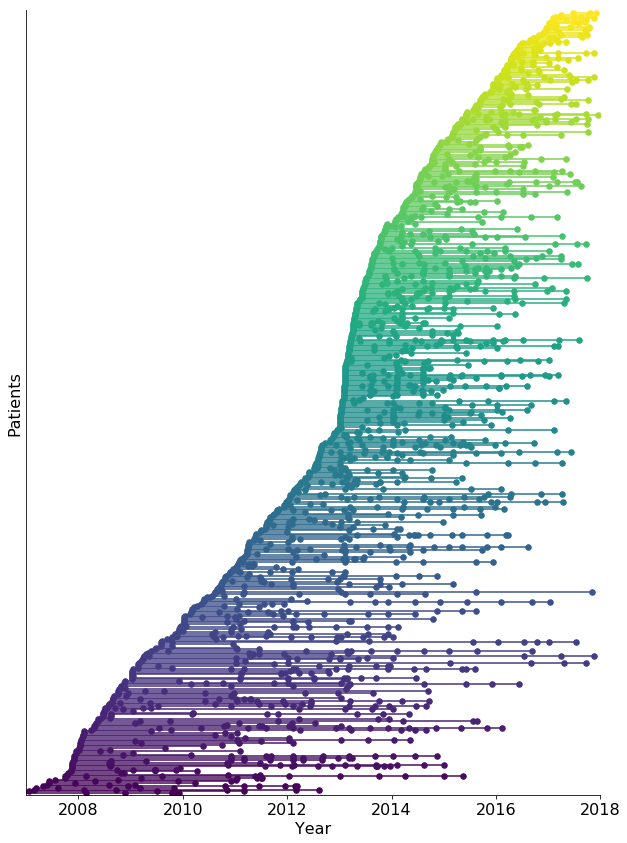

In [9]:
# First simple line plot
# Prepare figure
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(9,12))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Iterate through dates by increasing date
i = 0
for date in sorted(list(patients_by_first_date.keys())):
    # if there are more patients with same first date, sort by increasing end date
    if len(patients_by_first_date[date]) == 1:
        date_array = dates_by_patient[patients_by_first_date[date][0]]
        plt.plot(date_array, i*np.ones(len(date_array)), '-o',markersize=5.5, c=current_palette[i])
        i+=1
    else:
        # Sort by increasing end date
        enddates = [dates_by_patient[patid][-1] for patid in patients_by_first_date[date]]
        for k in np.argsort(enddates):
            date_array = dates_by_patient[patients_by_first_date[date][k]]
            plt.plot(date_array, i*np.ones(len(date_array)), '-o',markersize=5.5, c=current_palette[i])
            i+=1

ax.set_xlim([datetime.datetime(2007,1,1,0,0),datetime.datetime(2018,1,1,0,0)])
ax.set_ylim([-1, n_patients+1])

# hfont = {'fontname':'helvetica', 'fontweight':'bold'}
plt.ylabel('Patients')
plt.xlabel('Year')
ax.get_yaxis().set_ticks([])
plt.tight_layout()
plt.savefig('paper/figures/plots/patient_timelines_viridis.png')
plt.savefig('paper/figures/plots/patient_timelines_viridis.pdf', dpi=300)

## Second plot: distribution of max across patients
Plot the distribution of the peak values across patients and AB classes

In [10]:
# Before looking at temporal evolution, let's consider absolute measurements
for j in [1000, 2000, 5000, 10000, 15000]:
    print('In total there are {} entries with scores > {}'.format((df_filtered['I_VAL']>j).sum(), j))

In total there are 19807 entries with scores > 1000
In total there are 13278 entries with scores > 2000
In total there are 6573 entries with scores > 5000
In total there are 2146 entries with scores > 10000
In total there are 353 entries with scores > 15000


In [11]:
# We get the peak values matrix
AB_list = sorted(list(df_filtered['I_NAM'].unique().astype(str)))[:-1] # remove the nan column
# Need to invert DP and DR for plotting
AB_list = AB_list[:80] + AB_list[105:] + AB_list[98:105] + AB_list[80:98]
# The get all patient (we will only use patient with multiple measurements)
patient_list = sorted(list(df_filtered.index.unique()))
# For each patient extract the maximum values (and fill missing entries with 0)
DEFAULT_VALUE = 499
value_matrix = []
for patient in patient_list:
    values = df_filtered[df_filtered.index==patient].groupby('I_NAM').max()['I_VAL']
    complete_values = []
    for ab in AB_list:
        # try to get the value
        val = values.get(ab)
        if val and val!=np.nan:
            complete_values.append(val)
        else:
            complete_values.append(DEFAULT_VALUE)
    value_matrix.append(complete_values)
peak_values = np.asarray(value_matrix)

In [12]:
df_peak = pd.DataFrame(peak_values, index=patient_list, columns=AB_list)
# THere are 2 Nans:
df_peak[df_peak.isnull()] = DEFAULT_VALUE
df_peak.head()

,A1,A11,A2,A23,A24,A25,A26,A29,A3,A30,...,DP19,DP2,DP20,DP23,DP28,DP3,DP4,DP5,DP6,DP9
RS-1997-0034,499.0,2813.0,10050.0,8018.0,12442.0,9470.0,5989.0,6385.0,499.0,2438.0,...,581.0,7099.0,1436.0,2112.0,4870.0,499.0,9360.0,499.0,499.0,499.0
RS-2000-0356,499.0,499.0,499.0,499.0,499.0,499.0,499.0,499.0,499.0,499.0,...,499.0,499.0,499.0,499.0,499.0,499.0,499.0,499.0,499.0,499.0
RS-2001-0368,11544.0,14728.0,2141.0,5809.0,7915.0,11537.0,8463.0,10352.0,16086.0,9863.0,...,499.0,563.0,499.0,499.0,499.0,499.0,499.0,499.0,499.0,499.0
RS-2002-0057,499.0,1487.0,2578.0,775.0,804.0,499.0,499.0,499.0,499.0,499.0,...,499.0,499.0,499.0,499.0,499.0,499.0,499.0,499.0,1096.0,499.0
RS-2003-0488,499.0,499.0,499.0,499.0,499.0,1403.0,2014.0,499.0,499.0,499.0,...,499.0,499.0,499.0,499.0,499.0,499.0,499.0,499.0,499.0,499.0


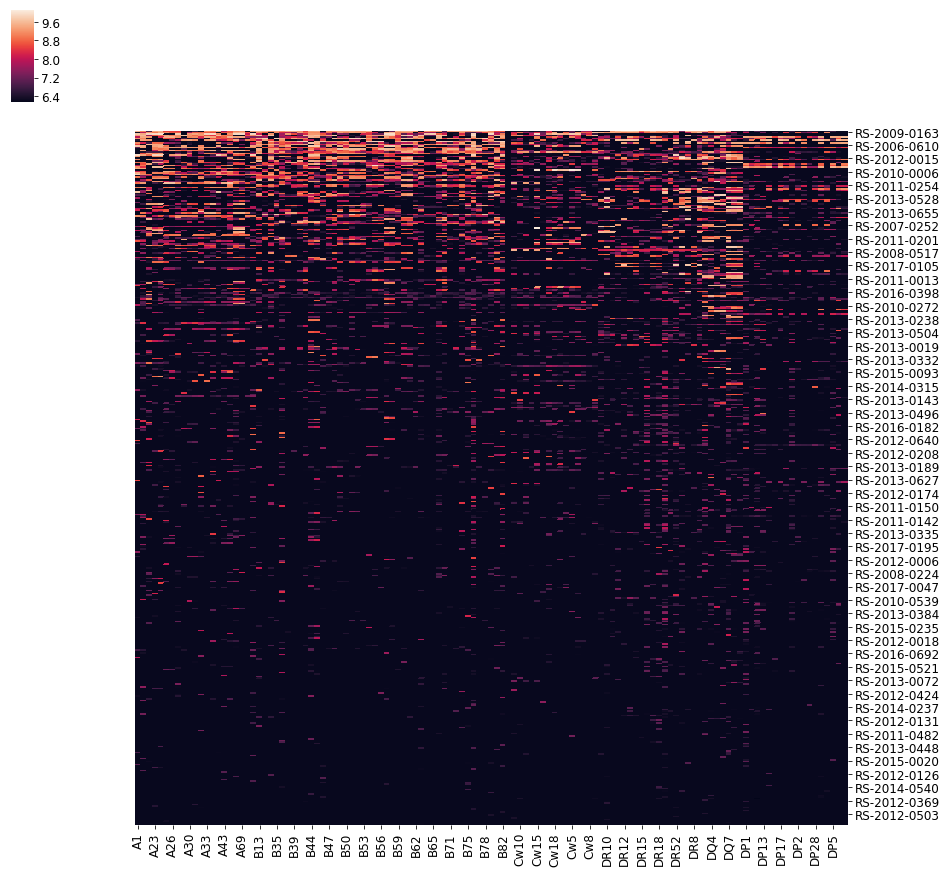

In [13]:
# There is a very large value that prevent nice plotting, let's put an upper bound:
# we can compute the sum of max MFI for a more ordered plotting
df_peak[df_peak>25000]=25000
df_peak['sum']=df_peak.sum(axis=1)
df_peak.sort_values('sum',ascending=False, inplace=True)
df_peak.drop(columns='sum', inplace=True)
plt.rcParams.update({'font.size': 12})
m = sns.clustermap(np.log(df_peak), figsize=(15,15), col_cluster=False, row_cluster=False)
plt.xticks = []

In [14]:
# Find out about the location of the loci in the dataset:
print("There are {} different antigens.")
counters = dict()
loci = ['A', 'B','Cw', 'DR', 'DQ', 'DP'] # There is one Bw but we will pool it in B
for l in loci:
    counters[l]=0
for a in df_peak.columns:
    prefix = ''.join([i for i in a if not i.isdigit()])
    if prefix == 'Bw':
        prefix = 'B'
    counters[prefix]+=1
for l in loci:
    print("{} in locus {}.".format(counters[l], l))

There are {} different antigens.
21 in locus A.
44 in locus B.
15 in locus Cw.
18 in locus DR.
7 in locus DQ.
18 in locus DP.


In [15]:
# Compute the ratios for plotting of the subaxes
ns = [21,44,15,18,7,18]
n = len(ns)
sums = [sum(ns[:i+1]) for i in range(n)]
ticks = [(sums[i]-0.5)/sum(ns) for i in range(n)]
ticks = [0.0] + ticks
ticks[-1] = 1.0
center_ticks = [(ticks[i]+ticks[i+1])/2 for i in range(n)]

In [16]:
print(ticks)
print(center_ticks)

[0.0, 0.16666666666666666, 0.524390243902439, 0.6463414634146342, 0.7926829268292683, 0.8495934959349594, 1.0]
[0.08333333333333333, 0.34552845528455284, 0.5853658536585367, 0.7195121951219512, 0.8211382113821138, 0.9247967479674797]


/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


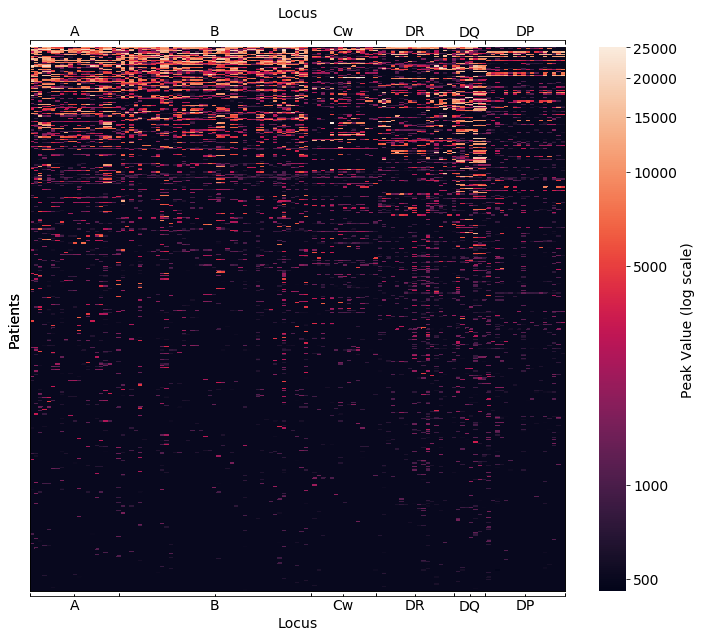

In [17]:
# Uncomment this instead if one wishes to use the clustermap clusters.
# reordered_rows = m.dendrogram_row.reordered_ind
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid.parasite_axes import SubplotHost
plt.rcParams.update({'font.size': 14})

fig1 = plt.figure(figsize=(12,10))
ax1 = SubplotHost(fig1, 111)
fig1.add_subplot(ax1)

# Colormap legend in log
from matplotlib.colors import LogNorm
import math
log_norm = LogNorm(vmin=df_peak.min().min(), vmax=df_peak.max().max())
# cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(df_peak.min().min())), 1+math.ceil(math.log10(df_peak.max().max())))]
cbar_ticks = [500,1000,5000,10000,15000,20000,25000]
# First X-axis
sns.heatmap(df_peak,norm=log_norm, cbar_kws={'label': 'Peak Value (log scale)',
                                                                  'ticks': cbar_ticks,
                                                                  'format': ticker.ScalarFormatter()})
# Uncomment this instead if one wishes to use the clustermap clusters.
# sns.heatmap(df_peak.iloc[reordered_rows],norm=log_norm, cbar_kws={'label': 'Peak Value (log scale)',
#                                                                   'ticks': cbar_ticks,
#                                                                   'format': ticker.ScalarFormatter()})
ax1.set_yticks([])
ax1.set_xticks([])
ax1.yaxis.set_label_text("Patients")

# Second X-axis
ax2 = ax1.twiny()
offset = 0, -5 # Position of the second axis
new_axisline = ax2.get_grid_helper().new_fixed_axis
ax2.axis["bottom"] = new_axisline(loc="bottom", axes=ax2, offset=offset)
ax2.xaxis.set_label_text('Locus') # Uncomment to label axis
ax2.xaxis.set_label_position('bottom') # Uncomment to label axis
# ax2.xaxis.set_ticks_position('both')
offset_top = 0, 7 # Position of the second axis
ax2.axis["top"] = new_axisline(loc="top", axes=ax2, offset=offset_top)

ax2.set_xticks(ticks)
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator(center_ticks))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(loci))



# plt.tight_layout()
plt.savefig('paper/figures/plots/patients_peak_values.png', dpi=300)
plt.savefig('paper/figures/plots/patients_peak_values.pdf', dpi=300)

In [18]:
# The heatmap could be a good contribution, but contains a bit too much information
# Let's pool the signals for each class of antibody (two ways: mean and max)
from collections import defaultdict
class_dict = defaultdict(list)
antibody_dict = dict()

plt.rcParams.update({'font.size': 12})
for a in AB_list:
    prefix = ''.join([i for i in a if not i.isdigit()])
    class_dict[prefix].append(a)
    antibody_dict[a]=prefix

In [19]:
class_dict.keys()

dict_keys(['A', 'B', 'Bw', 'Cw', 'DR', 'DQ', 'DP'])

In [20]:
# Create new tables
peak_values = df_peak.as_matrix()

summary_array_mean = []
summary_array_max = []
AB_series = list(class_dict.keys())
for ser in AB_series:
    # Start by extracting the relevant rows
    idx = []
    for i,d in enumerate(AB_list):
        if d in class_dict[ser]:
            idx.append(i)
    # Get matrix
    m = peak_values[:,idx]
    summary_array_mean.append(m.mean(axis=1))
    summary_array_max.append(m.max(axis=1))
series_max_values = np.array(summary_array_max).T
series_mean_values = np.array(summary_array_mean).T

In [21]:
df_max = pd.DataFrame(series_max_values, index=patient_list, columns=AB_series)

## Table 1 part 2 values

In [22]:
# From the peak values, take out some stats
# Simplify the problem and take max value for each class, align gender info
df_map = pd.read_csv("data/RS_nummer_age_sex.csv").set_index('RS Number')
df_peak_grouped = df_max.join(df_map['Sex'], how='left')

In [23]:
# Put this in a barplot instead
# INCLUSIVE CONDITIONS
# The conditions are the following 
CLINICAL_CUTOFF = 1500
# 1. Anti-A
label = ['Anti-A']
f = [lambda x: x['A']]
# 2. Anti-B
label += ['Anti-B']
f += [lambda x: (x['B'] or x['Bw'])]

# 3. Anti-A+B
label += ['Anti-A+B']
f += [lambda x: (x['B'] or x['Bw']) and x['A']]

# 2. Anti-C
label += ['Anti-C']
f += [lambda x: x['Cw']]


# 4. Anti-A+B+C
label += ['Anti-A+B+C']
f += [lambda x: (x['B'] or x['Bw']) and x['A'] and x['Cw']]

# 5. Anti-DP ONLY
label += ['Anti-DP']
f += [lambda x: x['DP']]

# 6. Anti-DR ONLY
label += ['Anti-DR']
f += [lambda x: x['DR']]

# 7. Anti-DP ONLY
label += ['Anti-DQ']
f += [lambda x: x['DQ']]

# 8. Anti-DP ONLY
label += ['Anti-DR+DQ']
f += [lambda x: x['DR'] and x['DQ']]

# 9. Anti-DP+DR+DQ
label += ['Anti-DP+DR+DQ']
f += [lambda x: x['DR'] and x['DQ'] and x['DP']]

# Sum until here is 467

In [24]:
for CLINICAL_CUTOFF in [1000,2000,5000,10000]:
    print(CLINICAL_CUTOFF)
    c = []
    for i in range(len(f)):
        x= (df_peak_grouped>CLINICAL_CUTOFF).apply(f[i], axis=1)
        print(f'{label[i]}: \t{np.sum(x)/len(x)}')
    x = (df_peak_grouped>CLINICAL_CUTOFF).drop(columns='Sex').values.any(axis=1)
    print(f'Overall: \t{np.sum(x)/len(x.ravel())}')
    print()

1000
Anti-A: 	0.4860813704496788
Anti-B: 	0.5610278372591007
Anti-A+B: 	0.3340471092077088
Anti-C: 	0.30406852248394006
Anti-A+B+C: 	0.1948608137044968
Anti-DP: 	0.3340471092077088
Anti-DR: 	0.4582441113490364
Anti-DQ: 	0.4089935760171306
Anti-DR+DQ: 	0.28693790149892934
Anti-DP+DR+DQ: 	0.15845824411134904
Overall: 	0.9229122055674518

2000
Anti-A: 	0.33832976445396146
Anti-B: 	0.4089935760171306
Anti-A+B: 	0.22483940042826553
Anti-C: 	0.19271948608137046
Anti-A+B+C: 	0.11349036402569593
Anti-DP: 	0.13062098501070663
Anti-DR: 	0.2569593147751606
Anti-DQ: 	0.2633832976445396
Anti-DR+DQ: 	0.14775160599571735
Anti-DP+DR+DQ: 	0.05139186295503212
Overall: 	0.702355460385439

5000
Anti-A: 	0.19271948608137046
Anti-B: 	0.2334047109207709
Anti-A+B: 	0.14346895074946467
Anti-C: 	0.07708779443254818
Anti-A+B+C: 	0.042826552462526764
Anti-DP: 	0.04925053533190578
Anti-DR: 	0.12205567451820129
Anti-DQ: 	0.15203426124197003
Anti-DR+DQ: 	0.07494646680942184
Anti-DP+DR+DQ: 	0.021413276231263382
Overa